#### Referenece
* https://www.kaggle.com/tuckerarrants/disaster-tweets-eda-glove-rnns-bert
* https://www.kaggle.com/andreshg/nlp-glove-bert-tf-idf-lstm-explained
* https://www.kaggle.com/ratan123/in-depth-guide-to-google-s-bert

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news/submit.csv
/kaggle/input/fake-news/train.csv
/kaggle/input/fake-news/test.csv


# Intro
* lable == 1: unreliable
* label == 0: reliable

In [2]:
import re
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau



from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


plt.style.use('seaborn')
sns.set(font_scale=2.5)
%matplotlib inline

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
train_df = pd.read_csv('/kaggle/input/fake-news/train.csv')
test_df = pd.read_csv('/kaggle/input/fake-news/test.csv')
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [6]:
train_df.describe()

,id,label
count,20800.000000,20800.000000
mean,10399.500000,0.500625
std,6004.587135,0.500012
min,0.000000,0.000000
25%,5199.750000,0.000000
50%,10399.500000,1.000000
75%,15599.250000,1.000000
max,20799.000000,1.000000


In [7]:
print("[title] ",train_df['title'][0])
print("[title] ",train_df['text'][0])

[title]  House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It
[title]  House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) 
With apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. 
As we now know, Comey notified the Republican chairmen and Democratic ranking members 

# EDA
* Label Percent
* Text length / Word length per Label Percent

In [8]:
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


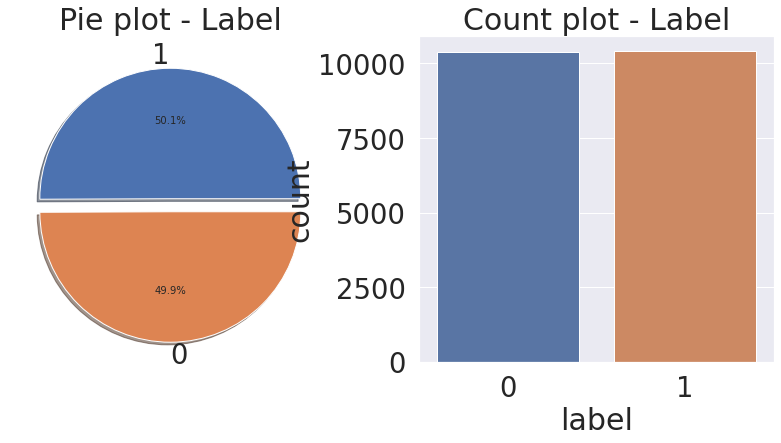

In [9]:
f,ax = plt.subplots(1,2,figsize=(14,6))
train_df['label'].value_counts().plot.pie(explode=[0, 0.1],autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Label')
ax[0].set_ylabel('')
sns.countplot('label', data = train_df, ax=ax[1])
ax[1].set_title('Count plot - Label')
plt.show()

In [10]:
def get_length_alphabets(text):
    text = str(text)
    return len(text)

In [11]:
def get_length_words(text):
    text = str(text)
    return len(text.split(' '))

In [12]:
train_df['length_alphabets'] = train_df['text'].apply(get_length_alphabets)
train_df['length_words'] = train_df['text'].apply(get_length_words)

In [13]:
train_df.head()

,id,title,author,text,label,length_alphabets,length_words
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,4930,820
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,4160,727
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,7692,1266
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,3237,559
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,938,154


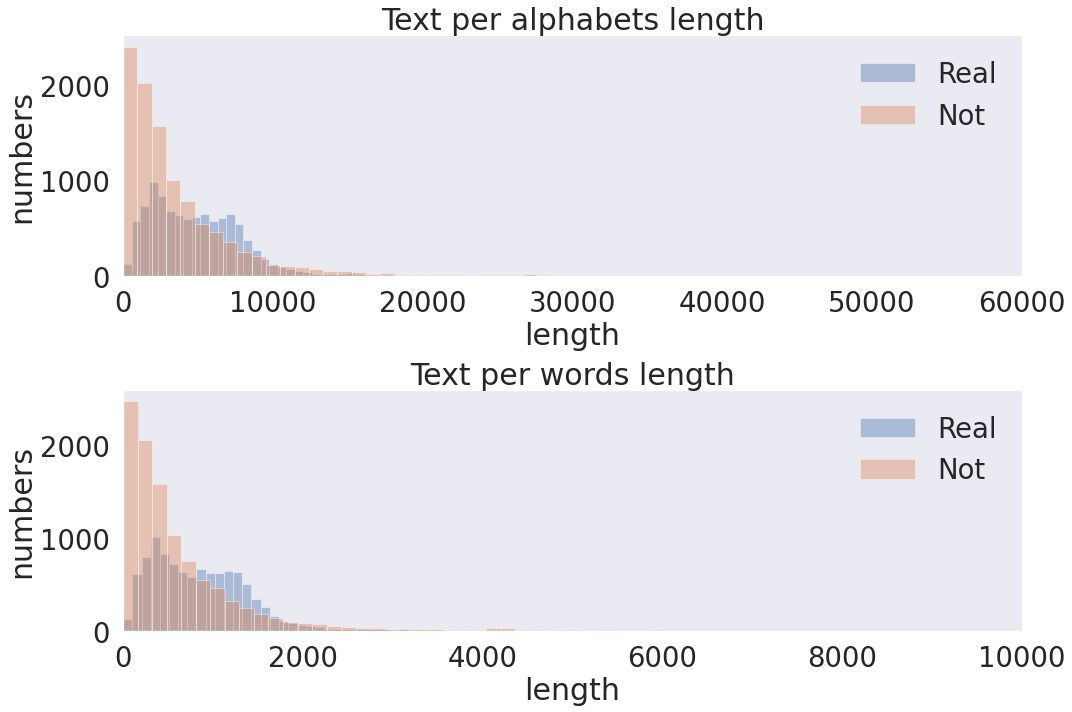

In [14]:
f, ax = plt.subplots(2,1,figsize=(15,10))

ax[0].set_title('Text per alphabets length')
ax[0].hist(train_df[train_df['label'] == 0]['length_alphabets'], alpha = 0.4, bins=150, label = 'Real')
ax[0].hist(train_df[train_df['label'] == 1]['length_alphabets'], alpha = 0.4, bins=150, label = 'Not')
ax[0].set_xlabel('length')
ax[0].set_ylabel('numbers')
ax[0].legend(loc='upper right')
ax[0].set_xlim(0,60000)
ax[0].grid()

ax[1].set_title('Text per words length')
ax[1].hist(train_df[train_df['label'] == 0]['length_words'], alpha = 0.4, bins=150, label = 'Real')
ax[1].hist(train_df[train_df['label'] == 1]['length_words'], alpha = 0.4, bins=150, label = 'Not')
ax[1].set_xlabel('length')
ax[1].set_ylabel('numbers')
ax[1].legend(loc='upper right')
ax[1].set_xlim(0,10000)
ax[1].grid()

f.tight_layout()
plt.show()

# Preprocessing
* Null Value Processing
* Drop Columns

In [15]:
train_df[train_df['text'].isnull()].head()

,id,title,author,text,label,length_alphabets,length_words
142,142,Gorafi Magazine : Entretien exclusif avec Bara...,NaN,NaN,1,3,1
573,573,Le top des recherches Google passe en top des ...,NaN,NaN,1,3,1
1200,1200,La Corée du Nord annonce avoir envoyé un missi...,NaN,NaN,1,3,1
1911,1911,Grand-Prix du Brésil – Romain Grosjean obtient...,NaN,NaN,1,3,1
2148,2148,Gorafi Magazine: Barack Obama « Je vous ai déj...,NaN,NaN,1,3,1


In [16]:
train_df['text'].fillna("", inplace=True)
test_df['text'].fillna("", inplace=True)

In [17]:
train_df[train_df['author'].isnull()].head()

,id,title,author,text,label,length_alphabets,length_words
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1,2729,489
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0,8177,1452
20,20,News: Hope For The GOP: A Nude Paul Ryan Has J...,NaN,Email \nSince Donald Trump entered the electio...,1,2231,377
23,23,Massachusetts Cop’s Wife Busted for Pinning Fa...,NaN,Massachusetts Cop’s Wife Busted for Pinning Fa...,1,2801,486
31,31,Israel is Becoming Pivotal to China’s Mid-East...,NaN,Country: Israel While China is silently playin...,1,7050,1146


In [18]:
train_df['author'] = train_df['author'].fillna('unknown')
test_df['author'] = test_df['author'].fillna('unknown')

In [19]:
train_df[train_df['title'].isnull()].head()

,id,title,author,text,label,length_alphabets,length_words
53,53,NaN,Dairy✓ᵀᴿᵁᴹᴾ,Sounds like he has our president pegged. What ...,1,679,131
120,120,NaN,Anonymous,"Same people all the time , i dont know how you...",1,135,16
124,124,NaN,SeekSearchDestory,"You know, outside of any morality arguments, i...",1,533,100
140,140,NaN,Anonymous,There is a lot more than meets the eye to this...,1,736,120
196,196,NaN,Raffie,They got the heater turned up on high.,1,38,8


In [20]:
# Get average title size
train_df['title_size'] = train_df['title'].apply(lambda x: len(str(x)))

# If title size == 3("NAN") then change title size = 0
train_nan_index = train_df[train_df['title_size']==3].index
train_df['title_size'][train_nan_index] = 0 

train_avg_title_size = int(train_df.value_counts(['title_size']).mean())
print("train avg_title_size: ",train_avg_title_size)

train avg_title_size:  98


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
# Get average title size
test_df['title_size'] = test_df['title'].apply(lambda x: len(str(x)))

# If title size == 3("NAN") then change title size = 0
test_nan_index = test_df[test_df['title_size']==3].index
test_df['title_size'][test_nan_index] = 0 

test_avg_title_size = int(test_df.value_counts(['title_size']).mean())
print("test avg_title_size: ",test_avg_title_size)

test avg_title_size:  33


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
#change title "NAN" to text[:98]
train_df['title'][train_nan_index] = train_df['text'][train_nan_index].apply(lambda x: str(x)[:train_avg_title_size])

test_df['title'][test_nan_index] = test_df['text'][test_nan_index].apply(lambda x: str(x)[:test_avg_title_size])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [23]:
train_df[train_df['id']==120]

,id,title,author,text,label,length_alphabets,length_words,title_size
120,120,"Same people all the time , i dont know how you...",Anonymous,"Same people all the time , i dont know how you...",1,135,16,0


In [24]:
train_df.head()

,id,title,author,text,label,length_alphabets,length_words,title_size
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,4930,820,81
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,4160,727,55
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,7692,1266,33
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,3237,559,63
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,938,154,93


In [25]:
train_df.isnull().sum()

id                  0
title               0
author              0
text                0
label               0
length_alphabets    0
length_words        0
title_size          0
dtype: int64

In [26]:
train_df.drop(['length_alphabets','length_words','title_size'], axis=1, inplace = True)
test_df.drop(['title_size'], axis=1, inplace = True)

In [27]:
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [28]:
test_df.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,unknown,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


# Feature Engineering
* Concat "author" & "text" Columns
* Nomalization
* Plot WordClouds
* Words Tokenization
* Split Train / Test / Validation Data

In [29]:
train_df['text']= train_df['author'] + " " + train_df['text']
test_df['text']= test_df['author'] + " " + test_df['text']

In [30]:
train_df.drop(['id','title','author'], axis=1, inplace=True)
test_df.drop(['id','title','author'], axis=1, inplace=True)

In [31]:
train_df['text'][0]

'Darrell Lucus House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was 

In [32]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

In [33]:
def preprocess(text,stem=False):
    text = text.lower()  # lowercase

    text = re.sub(r'[!]+', '!', text)
    text = re.sub(r'[?]+', '?', text)
    text = re.sub(r'[.]+', '.', text)
    text = re.sub(r"'", "", text)
    text = re.sub('\s+', ' ', text).strip()  # Remove and double spaces
    text = re.sub(r'&amp;?', r'and', text)  # replace & -> and
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)  # Remove URLs
    # remove some puncts (except . ! # ?)
    text = re.sub(r'[:"$%&\*+,-/:;<=>@\\^_`{|}~]+', '', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'EMOJI', text)
    
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(lemmatizer.lemmatize(token))
    return " ".join(tokens)

In [34]:
train_df['text'] = train_df['text'].apply(lambda x: preprocess(x))
test_df['text'] = test_df['text'].apply(lambda x: preprocess(x))

#### WordCloud
* Label == 0 Real News
* Label == 1 Fake News

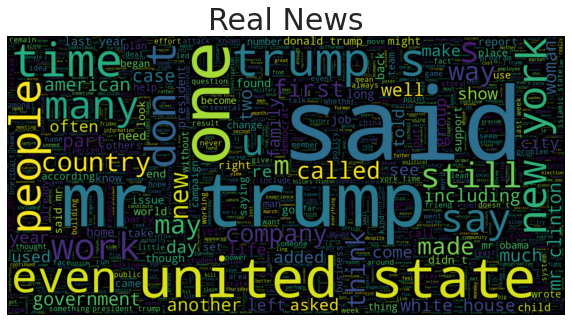

In [35]:
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(train_df[train_df.label == 0].text))
plt.axis('off')
plt.title('Real News')
plt.imshow(wc,interpolation = 'bilinear')

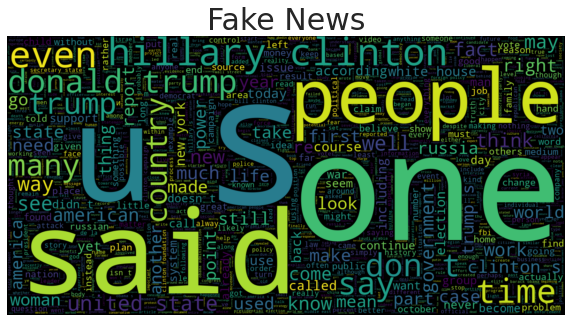

In [36]:
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(train_df[train_df.label == 1].text))
plt.axis('off')
plt.title('Fake News')
plt.imshow(wc,interpolation = 'bilinear')

In [37]:
x_train = train_df['text']
y_train = train_df['label']

In [38]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [39]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

In [40]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocab size : ",vocab_size)

Vocab size :  227108


In [41]:
x_train = pad_sequences(
    tokenizer.texts_to_sequences(x_train),
    maxlen = 256)
x_val = pad_sequences(
    tokenizer.texts_to_sequences(x_val),
    maxlen = 256)
x_test = pad_sequences(
    tokenizer.texts_to_sequences(test_df['text']),
    maxlen = 256)

In [42]:
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_val shape: (4160, 256)
y_val shape: (4160,)


In [43]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("First Train data squence info : ", x_train[0].shape)
print(x_train[0])

x_train shape: (16640, 256)
y_train shape: (16640,)
First Train data squence info :  (256,)
[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0  81233   1896 113000  65876  45092   2708    283    620
    163   6100   3386   1495   3084      9   1419    818    638     29
   4240    200   1130   1107    310   1470   1173   1130   4546    620
    542    604   1131   2583     29    833    151      9    638    801
    294     79   3146   1732   5430    257   6938    752     14   1972
   2742    697   2611    133   5877      9    107   6172

# Modeling
### - LSTM Modeling

In [44]:
inputs = Input(shape=(256,), dtype='int32')

embedding = tf.keras.layers.Embedding(vocab_size, 300)(inputs)
net = SpatialDropout1D(0.2)(embedding)
net = Bidirectional(LSTM(128,dropout=0.2, recurrent_dropout=0.2))(net)
net = Dense(64,activation = 'relu')(net)
net = Dropout(0.3)(net)
net = Dense(1,activation = 'sigmoid')(net)

outputs = net
model = tf.keras.Model(inputs,outputs)

In [45]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 256, 300)          68132400  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 256, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               439296    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65    

In [46]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [47]:
history = model.fit(
    x_train,
    y_train,
    batch_size=1024, 
    epochs=10,
    validation_data=(x_val, y_val)
)

Epoch 1/10
17/17 [==============================] - 60s 3s/step - loss: 0.6544 - accuracy: 0.6079 - val_loss: 0.3539 - val_accuracy: 0.9262
Epoch 2/10
17/17 [==============================] - 54s 3s/step - loss: 0.2342 - accuracy: 0.9397 - val_loss: 0.1327 - val_accuracy: 0.9575
Epoch 3/10
17/17 [==============================] - 53s 3s/step - loss: 0.0508 - accuracy: 0.9850 - val_loss: 0.1243 - val_accuracy: 0.9615
Epoch 4/10
17/17 [==============================] - 53s 3s/step - loss: 0.0175 - accuracy: 0.9955 - val_loss: 0.1210 - val_accuracy: 0.9623
Epoch 5/10
17/17 [==============================] - 52s 3s/step - loss: 0.0067 - accuracy: 0.9989 - val_loss: 0.1505 - val_accuracy: 0.9654
Epoch 6/10
17/17 [==============================] - 54s 3s/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.1637 - val_accuracy: 0.9615
Epoch 7/10
17/17 [==============================] - 53s 3s/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.1662 - val_accuracy: 0.9639
Epoch 8/10
17/17 [==

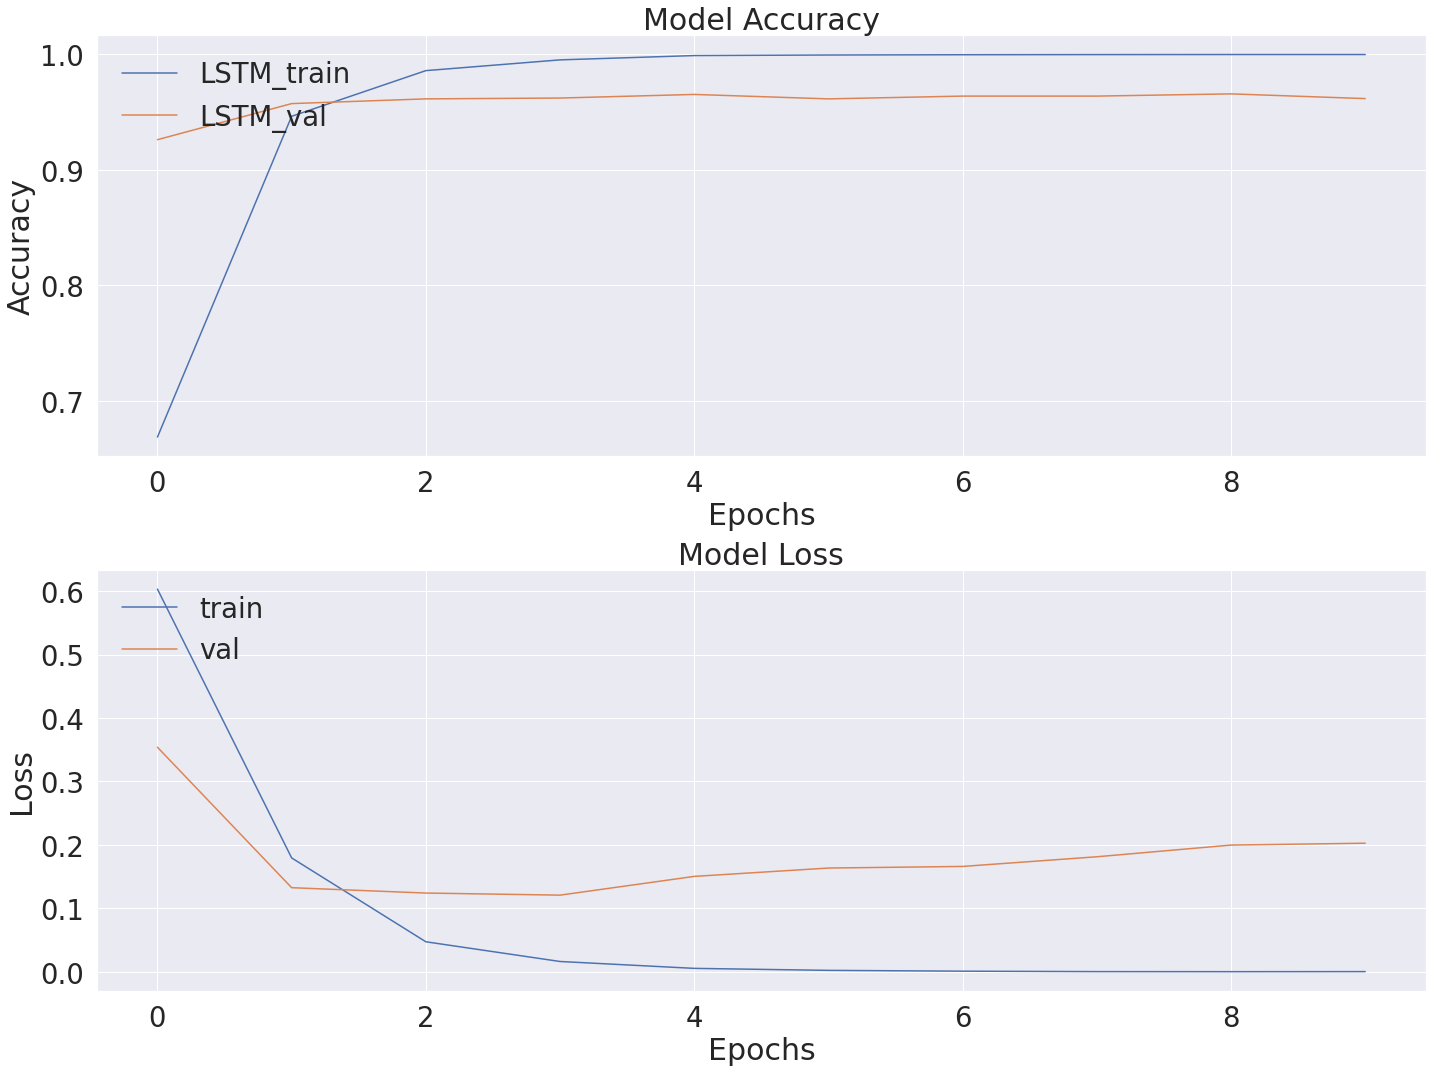

In [48]:
f,ax = plt.subplots(2,1,figsize=(20,15))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend(['LSTM_train', 'LSTM_val'], loc='upper left')


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['train', 'val'], loc = 'upper left')

f.tight_layout()
plt.show()

### - BERT Modeling

In [49]:
!pip install --quiet transformers
from transformers import TFBertModel, BertTokenizer

In [50]:
#get BERT layer
bert_layers = TFBertModel.from_pretrained('bert-base-uncased')

#get BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [51]:
encode = bert_tokenizer.encode("Hi nice meet you !")
decode = bert_tokenizer.decode(encode)

print("Encode: ", encode)
print("Decode: ", decode)

Encode:  [101, 7632, 3835, 3113, 2017, 999, 102]
Decode:  [CLS] hi nice meet you! [SEP]


In [52]:
def bert_encode(data, max_len) :
    input_ids = [] 
    attention_masks = []
    
    for i in range(len(data)):
        encoded = bert_tokenizer.encode_plus(data[i],
                                        add_special_tokens=True,
                                        max_length=max_len,
                                        pad_to_max_length=True,
                                        return_attention_mask=True)
        
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [53]:
x_train_bert = train_df['text']
y_train_bert = train_df['label']

train_input_ids, train_attention_masks = bert_encode(x_train_bert,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [54]:
input_ids = tf.keras.Input(shape=(60,),dtype='int32',name='input_ids')
attention_masks = tf.keras.Input(shape=(60,),dtype='int32',name='attention_masks')

output = bert_layers([input_ids,attention_masks])
output = output[1]
net = tf.keras.layers.Dense(32,activation='relu')(output)
net = tf.keras.layers.Dropout(0.2)(net)
net = tf.keras.layers.Dense(1,activation='sigmoid')(net)
outputs = net

model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = outputs)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


In [55]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [56]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 60)]         0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_masks[0][0]            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           24608       tf_bert_model[0][1]        

In [57]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    y_train_bert,
    validation_split=0.2, 
    epochs=10,
    batch_size=32)

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/10


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


520/520 [==============================] - ETA: 0s - loss: 0.3127 - accuracy: 0.8500

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


520/520 [==============================] - 133s 241ms/step - loss: 0.3125 - accuracy: 0.8501 - val_loss: 0.0772 - val_accuracy: 0.9750
Epoch 2/10
520/520 [==============================] - 124s 238ms/step - loss: 0.0477 - accuracy: 0.9861 - val_loss: 0.0513 - val_accuracy: 0.9817
Epoch 3/10
520/520 [==============================] - 124s 238ms/step - loss: 0.0250 - accuracy: 0.9931 - val_loss: 0.0381 - val_accuracy: 0.9868
Epoch 4/10
520/520 [==============================] - 124s 238ms/step - loss: 0.0144 - accuracy: 0.9960 - val_loss: 0.0365 - val_accuracy: 0.9894
Epoch 5/10
520/520 [==============================] - 124s 238ms/step - loss: 0.0071 - accuracy: 0.9984 - val_loss: 0.0539 - val_accuracy: 0.9863
Epoch 6/10
520/520 [==============================] - 124s 238ms/step - loss: 0.0037 - accuracy: 0.9994 - val_loss: 0.0527 - val_accuracy: 0.9870
Epoch 7/10
520/520 [==============================] - 124s 238ms/step - loss: 0.0095 - accuracy: 0.9970 - val_loss: 0.0450 - val_accura

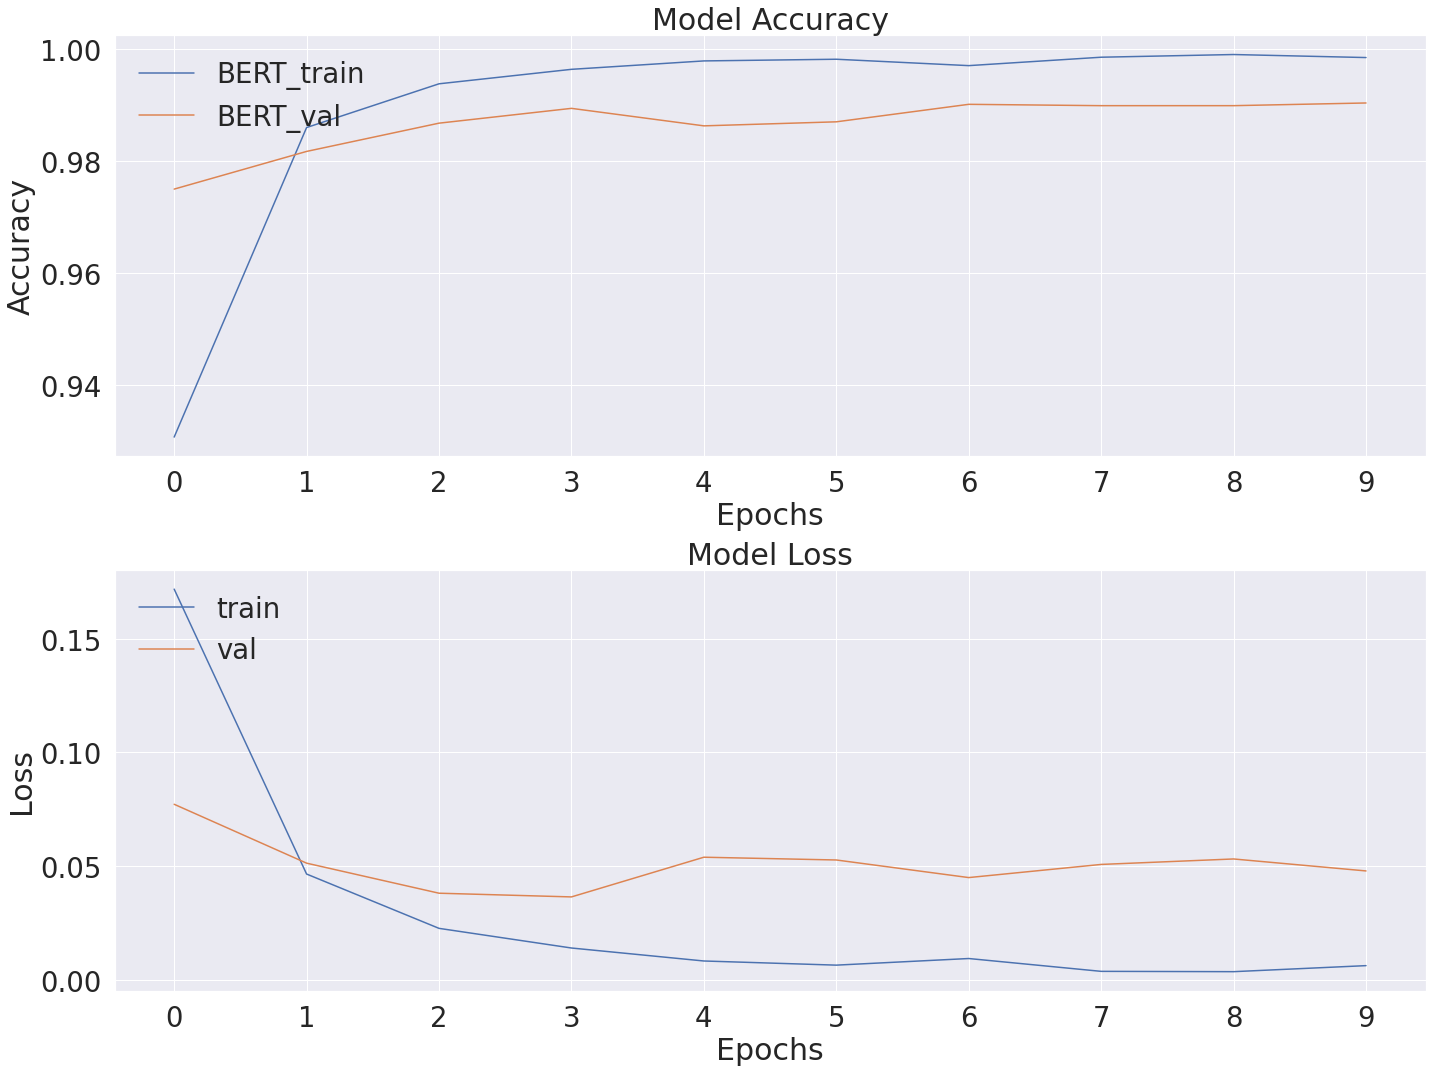

In [58]:
f,ax = plt.subplots(2,1,figsize=(20,15))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_xticks([0,1,2,3,4,5,6,7,8,9])
ax[0].legend(['BERT_train', 'BERT_val'], loc='upper left')


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_xticks([0,1,2,3,4,5,6,7,8,9])
ax[1].legend(['train', 'val'], loc = 'upper left')

f.tight_layout()
plt.show()

# Submission
* get sample_submission.csv

In [59]:
submission = pd.read_csv('/kaggle/input/fake-news/submit.csv')
submission.shape

(5200, 2)

In [60]:
submission.head()

,id,label
0,20800,0
1,20801,1
2,20802,0
3,20803,1
4,20804,1


In [61]:
test_df.head()

,text
0,david streitfeld palo alto calif — year scorni...
1,unknown russian warship ready strike terrorist...
2,common dream video #nodapl native american lea...
3,daniel victor first don’t succeed try differen...
4,truth broadcast network 42 min ago 1 view 0 co...


In [62]:
bert_x_test = test_df['text']

In [63]:
test_input_ids, test_attention_masks = bert_encode(bert_x_test,60)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [64]:
pred = model.predict([test_input_ids,test_attention_masks])

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


In [65]:
pred[:5]

array([[3.1985499e-05],
       [9.9998546e-01],
       [9.9998438e-01],
       [2.6762189e-05],
       [9.9998510e-01]], dtype=float32)

In [66]:
submission['label'] = (pred>0.5).astype(int)

In [67]:
submission.head()

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1


In [68]:
submission.to_csv('submission.csv', index=False)

### THX to Reading My Notebook🌈